In [16]:
"""
Initial setup:
1) create virtualenv project using pycharm

2) install the following libraries to virtualenv:
pip install numpy
pip install pandas
pip install requests
pip install beautifulsoup4
pip install lxml
"""

'\nInitial setup:\n1) create virtualenv project using pycharm\n\n2) install the following libraries to virtualenv:\npip install numpy\npip install pandas\npip install requests\npip install beautifulsoup4\npip install lxml\n'

In [1]:
import requests  # library to send requests to web site(krisha.kz)
from bs4 import BeautifulSoup as bs  # library to copy all html-code
import csv  # library to write info to csv
import pandas as pd  # to convert csv to pandas DataFrame
import numpy as np  # to work np. arrays
import time
import math
import re

In [18]:
headers = {
    'accept': '*/*',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36'
}

items_per_page = 12

def get_all_pages(catalog_page_url):
    urls = []
    urls.append(catalog_page_url)
    session = requests.Session()
    request = session.get(catalog_page_url, headers=headers)

    if request.status_code == 200:
        soup = bs(request.content, 'lxml')
        try:
            pagination = soup.select('li.tree__item._expanded._active')
            total_items = int(re.sub('\D', '', pagination[0].text))
            pages = math.ceil(total_items / items_per_page)
            for i in range(2, pages):
                url = catalog_page_url + '?page={i}'.format(i=i)
                if url not in urls:
                    urls.append(url)
        except Exception as e:
            print("exception while getting all page urls: " + e)
            pass
    return urls

def parse_kaspi_pages(urls):
    items = []
    session = requests.Session()
    for url in urls:
        time.sleep(1)
        print("parsing: " + url)

        request = session.get(url, headers=headers)
        soup = bs(request.content, 'lxml')
        divs = soup.find_all('div', attrs={'class': 'item-card ddl_product'})
        for div in divs:
            title = div.find('a', attrs={'class': 'item-card__name ddl_product_link'}).string.strip()
            price = div.find('span', attrs={'class': 'item-card__prices-price'}).string.strip()
            rating_div = div.find('div', attrs={'class': 'item-card__rating'})
            rating_element = rating_div.find('a', attrs={'class': 'ddl_product_link'})
            rating = ""
            if rating_element is not None:
                rating = re.search(r'\d+', str(rating_element.string)).group()

            items.append({
                'title': title,
                'price': price,
                'rating': rating,
            })
    print(len(items))
    return items


def files_writer(flats):
    # with open('HeadHunter.csv', 'a', encoding='utf-8') as file:
    with open(r"Kaspi.csv", "w", encoding='utf-8') as file:
        a_pen = csv.writer(file)
        a_pen.writerow(('title', 'price', 'rating'))
        for flat in flats:
            a_pen.writerow((flat['title'], flat['price'], flat['rating']))

base_url = 'https://kaspi.kz/shop/c/notebooks/'
urls = get_all_pages(base_url)
items = parse_kaspi_pages(urls)
files_writer(items)

parsing: https://kaspi.kz/shop/c/notebooks/


KeyboardInterrupt: 

In [22]:
import csv

items = []
with open('Kaspi.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    initial = True
    for row in spamreader:
        if not initial:
            title = row[0].split(" ")
            price = re.sub('\D', '', row[1])
            rating = row[2]

            items.append({
                'brand': title[0],
                'color': title[-1],
                'full_name': ' '.join(title[:-1]),
                'price': price,
                'rating': rating,
            })
        else:
            initial = False

print(items[0])
def files_writer(items):
    # with open('HeadHunter.csv', 'a', encoding='utf-8') as file:
    with open(r"Kaspi.csv", "w", encoding='utf-8') as file:
        a_pen = csv.writer(file)
        a_pen.writerow(('brand', 'color', 'full_name', 'price', 'rating'))
        for item in items:
            a_pen.writerow((item['brand'], item['color'], item['full_name'], item['price'], item['rating']))

files_writer(items)

{'brand': 'Lenovo', 'color': 'серый', 'full_name': 'Lenovo V14-ADA 82C6S03900', 'price': '184800', 'rating': '297'}


In [23]:
df = pd.read_csv('Kaspi.csv')

In [24]:
df.head()

,brand,color,full_name,price,rating
0,Lenovo,серый,Lenovo V14-ADA 82C6S03900,184800,297.0
1,Leap,белый,Leap T304 PT00070,97520,175.0
2,Apple,серый,Apple MacBook Air 13 MGN63,547250,311.0
3,Apple,серый,Apple MacBook Pro 13 MYD82,628550,137.0
4,Acer,черный,Acer Aspire 5 A515-45G NX.A8EER.00A,319990,26.0


In [25]:
df.shape

(1368, 5)

In [27]:
df.head()

,brand,color,full_name,price,rating
0,Lenovo,серый,Lenovo V14-ADA 82C6S03900,184800,297.0
1,Leap,белый,Leap T304 PT00070,97520,175.0
2,Apple,серый,Apple MacBook Air 13 MGN63,547250,311.0
3,Apple,серый,Apple MacBook Pro 13 MYD82,628550,137.0
4,Acer,черный,Acer Aspire 5 A515-45G NX.A8EER.00A,319990,26.0


In [28]:
df.shape

(1368, 5)

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [30]:
df1 = df.groupby(['brand']).size().reset_index(name='count')
df1.sort_values(by=['count'], inplace=True)
df1

,brand,count
17,KUULAA,1
31,YAYA,1
2,Aiwa,1
5,Aсer,1
28,Qmax,1
25,Microsoft,1
10,Digma,1
20,Leen,1
30,Samsung,2
7,Colorful,2


In [31]:
df1.set_index('brand', inplace=True)

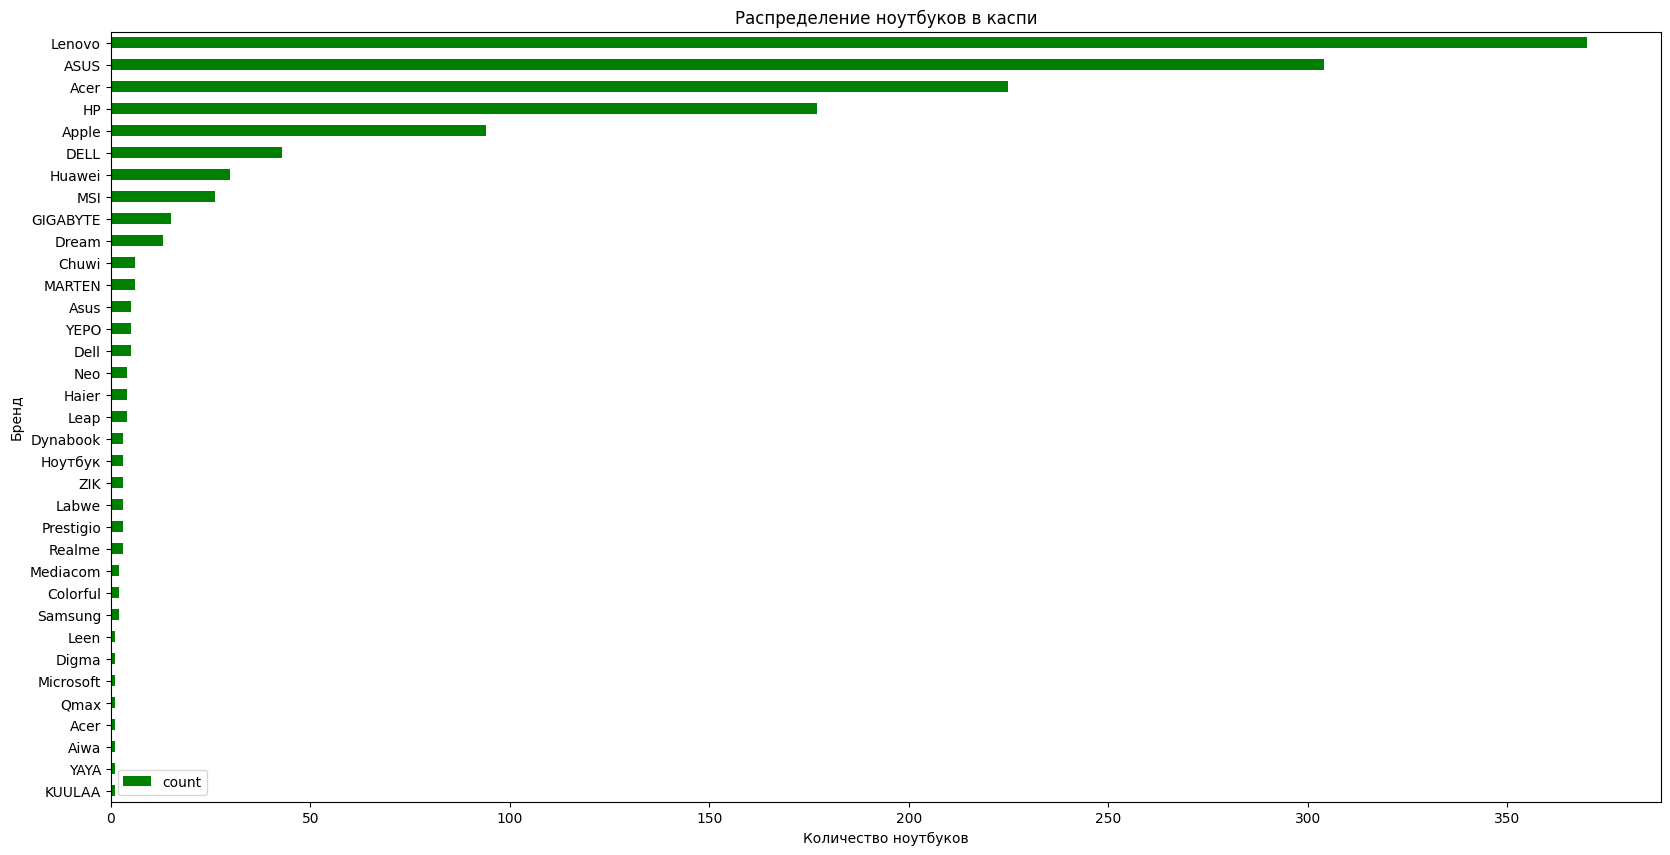

In [32]:
df1.plot(kind='barh', 
             stacked=False,
             figsize=(20, 10),
             color='g',
             label=df1['count']
             )

plt.title('Распределение ноутбуков в каспи')
plt.xlabel('Количество ноутбуков')
plt.ylabel('Бренд')
plt.show()

In [33]:
df2 = df.copy()

In [34]:
df2.head()

,brand,color,full_name,price,rating
0,Lenovo,серый,Lenovo V14-ADA 82C6S03900,184800,297.0
1,Leap,белый,Leap T304 PT00070,97520,175.0
2,Apple,серый,Apple MacBook Air 13 MGN63,547250,311.0
3,Apple,серый,Apple MacBook Pro 13 MYD82,628550,137.0
4,Acer,черный,Acer Aspire 5 A515-45G NX.A8EER.00A,319990,26.0


In [35]:
df2.shape

(1368, 5)

TypeError: can only concatenate str (not "float") to str

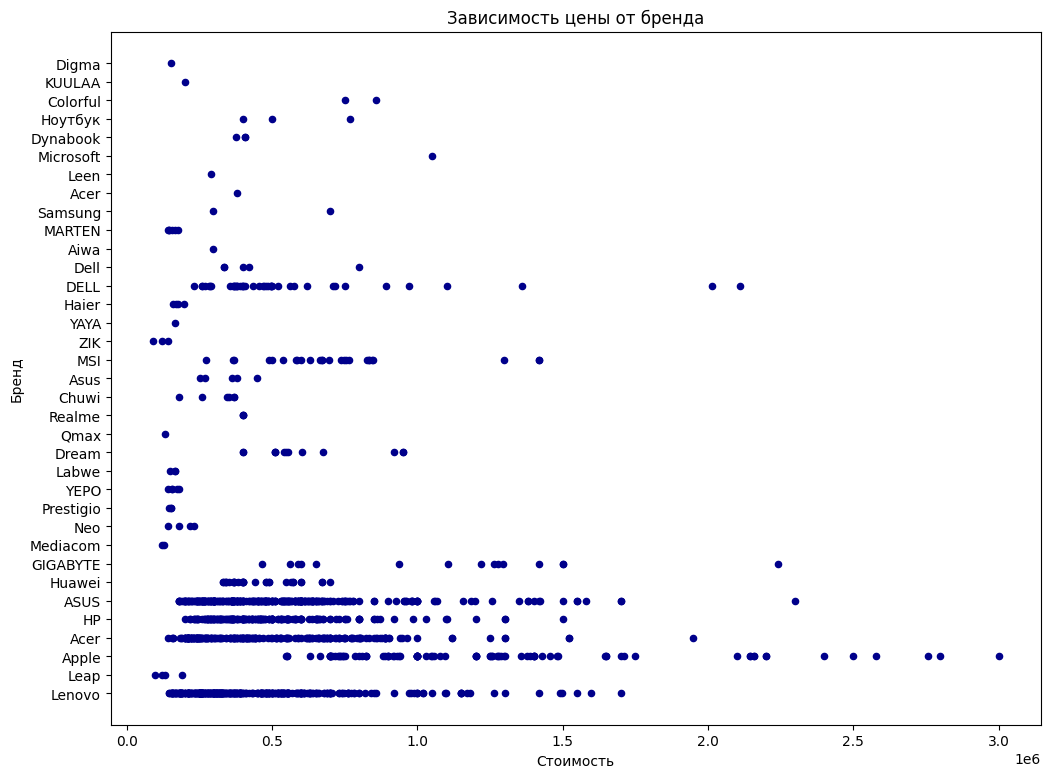

In [39]:
df2.plot(kind='scatter', x='price', y='brand', figsize=(12, 9), color='darkblue')

plt.title('Зависимость цены от бренда')
plt.xlabel('Стоимость')
plt.ylabel('Бренд')

x = df2['price']
y = df2['brand']
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')

plt.show()

In [ ]:
df4 = df.groupby(['district']).sum()
#df4.sort_values(by=['count'], inplace=True)
df4

In [ ]:
n_groups = 8

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35

rects1 = plt.barh(index + bar_width, df4['owner'], bar_width,
color='b',
label='Хозяин')

rects2 = plt.barh(index, df4['specialist'], bar_width,
color='g',
label='Риэлтор')

plt.ylabel('Районы')
plt.xlabel('Количество квартир')
plt.title('Распределение арендного жилья в городе Алматы')
plt.yticks(index + bar_width/2, df4.index)
plt.legend()

In [ ]:
df.head()

In [ ]:
df5 = df.groupby(['rooms']).size().reset_index(name='count')
df5.sort_values(by=['count'], inplace=True)
df5.set_index('rooms', inplace=True)
df5

In [ ]:
df5.plot(kind='barh', 
             stacked=False,
             figsize=(20, 10),
             color='g',
             label=df5['count']
             )

plt.title('Распределение арендного жилья в городе Алматы')
plt.xlabel('Количество квартир')
plt.ylabel('Районы')
plt.show()

In [ ]:
df6 = df.groupby(['district','price']).size().reset_index(name='count')
df6.sort_values(by=['count'], inplace=True)
df6 = df6.pivot(index='price',columns='district',values='count')

In [ ]:
df6